In [58]:
def load_mnist(path, kind="train"):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, "%s-labels-idx1-ubyte.gz" % kind)
    images_path = os.path.join(path, "%s-images-idx3-ubyte.gz" % kind)

    with gzip.open(labels_path, "rb") as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, "rb") as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(
            len(labels), 784
        )

    return images, labels

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [42]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
# Download the train and test data
trainset = datasets.FashionMNIST(
    "~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform
)
testset = datasets.FashionMNIST(
    "~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform
)

# Validation Set
index = list(range(len(trainset)))
np.random.shuffle(index)
validation_split = int(np.floor(0.2 * len(trainset)))
train = SubsetRandomSampler(index[:validation_split])
validation = SubsetRandomSampler(index[validation_split:])


# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [33]:
label_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

/var/folders/8j/r8s_wt752_n9qp37zrrqv0lm0000gn/T/ipykernel_1674/153356287.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


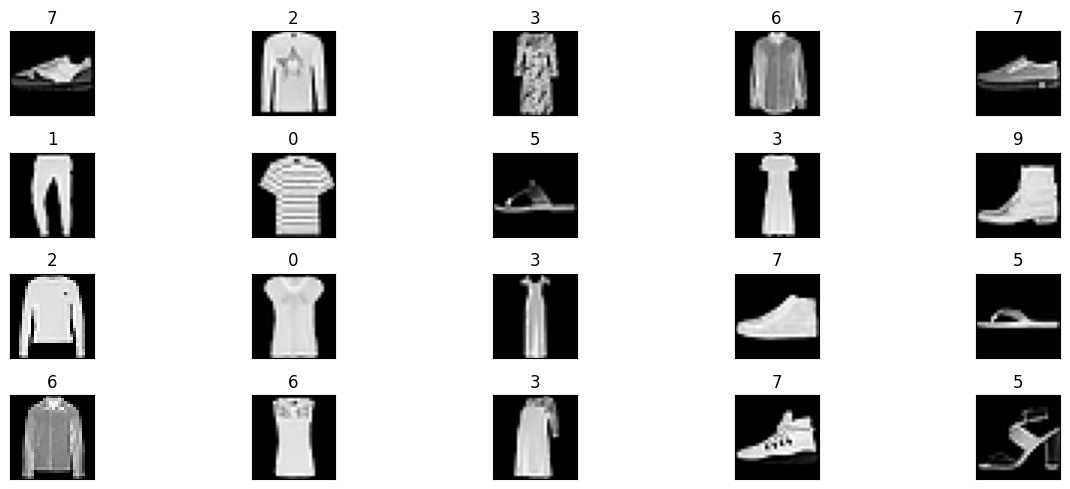

In [26]:
iterator = iter(trainloader)
images, labels = next(iter(trainloader))
fig = plt.figure(figsize=(15, 5))
for id in np.arange(20):
    ax = fig.add_subplot(4, 20//4, id+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[id]), cmap='gray')
    ax.set_title(labels[id].item())
    fig.tight_layout()


64

In [78]:
# cnn define cnn model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )

        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        # )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        # first hidden layer
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=2, stride=2)

        # second hidden layer
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=2)

        # third hidden layer
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)

        # fourth hidden layer
        out = self.fc2(out)

        # output layer
        out = self.fc3(out)

        return out


model = CNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [79]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1

        if not (count % 50):    # It's same as "if count % 50 == 0"
                total = 0
                correct = 0
            
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                
                    test = Variable(images.view(100, 1, 28, 28))
                
                    outputs = model(test)
                
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                
                    total += len(labels)
                
                accuracy = correct * 100 / total
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/Users/parimi/anaconda3/envs/mathenv/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.2793242037296295, Accuracy: 85.19000244140625%
Iteration: 1000, Loss: 0.16749633848667145, Accuracy: 89.54000091552734%
Iteration: 1500, Loss: 0.23099634051322937, Accuracy: 89.51000213623047%
Iteration: 2000, Loss: 0.298138290643692, Accuracy: 89.88999938964844%
Iteration: 2500, Loss: 0.1637721061706543, Accuracy: 90.0199966430664%
Iteration: 3000, Loss: 0.20130901038646698, Accuracy: 89.83999633789062%


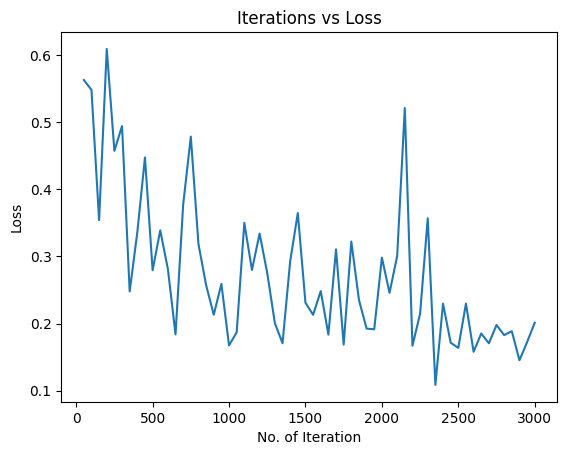

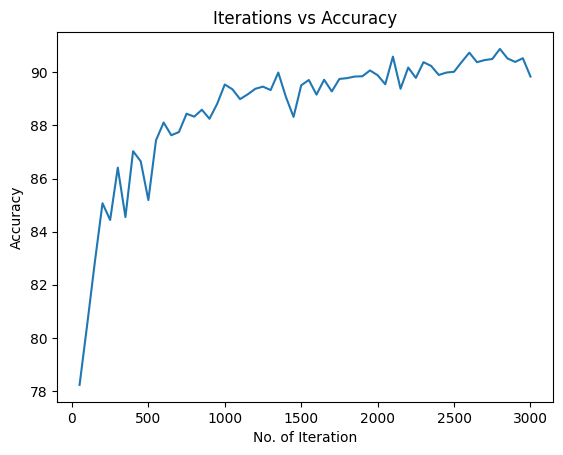

In [80]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [49]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_mapping[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 86.10%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 85.20%
Accuracy of Dress: 91.00%
Accuracy of Coat: 90.20%
Accuracy of Sandal: 99.10%
Accuracy of Shirt: 72.40%
Accuracy of Sneaker: 95.90%
Accuracy of Bag: 98.20%
Accuracy of Ankle Boot: 96.80%
